<class 'pandas.core.frame.DataFrame'>
RangeIndex: 803 entries, 0 to 802
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       803 non-null    int64 
 1   video    803 non-null    object
 2   emotion  803 non-null    object
dtypes: int64(1), object(2)
memory usage: 18.9+ KB
None

Sample data:
   id                                              video   emotion
0   1  https://www.instagram.com/reel/DNKcHgdA-d1/?ig...  Surprise
1   2  https://www.instagram.com/reel/DNHwrh2gnBm/?ig...  Surprise
2   3  https://www.instagram.com/reel/DM7QsjnRCoa/?ig...  Surprise
3   4  https://www.instagram.com/reel/DNBBEt6Paxj/?ig...  Surprise
4   5  https://www.instagram.com/reel/DMz13fQzZsN/?ig...     Proud
5   6  https://www.instagram.com/reel/DMz1mj7s6u7/?ig...  Surprise


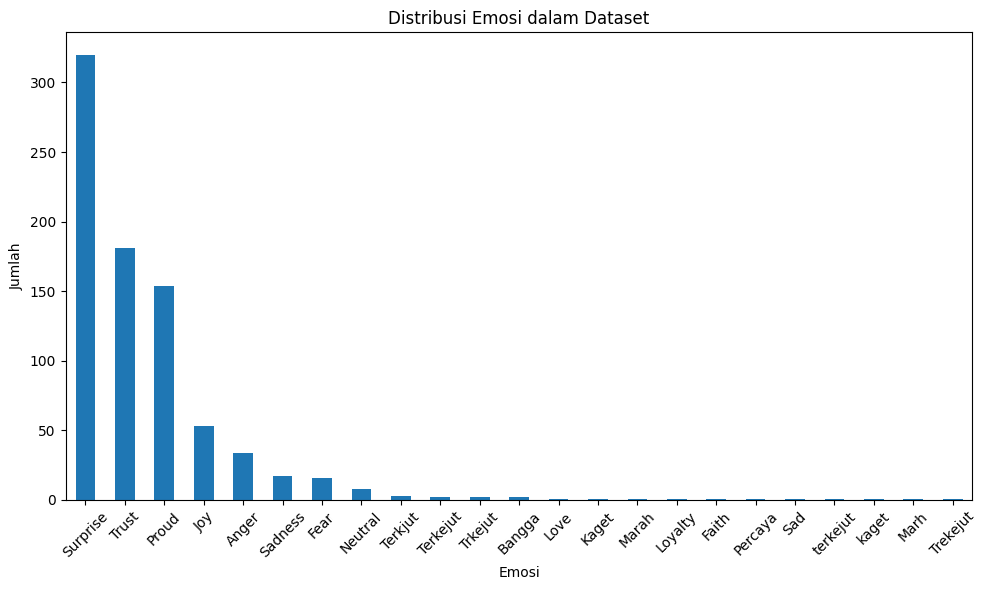

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings

df = pd.read_csv('/content/datatrain.csv')
print(df.info())
print("\nSample data:")
print(df.head(6))
emotion_counts = df['emotion'].value_counts()

# Visualisasi emosi
plt.figure(figsize=(10, 6))
emotion_counts.plot(kind='bar')
plt.title('Distribusi Emosi dalam Dataset')
plt.xlabel('Emosi')
plt.ylabel('Jumlah')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Data time series harian:
emotion     Anger  Bangga  Faith  Fear  Joy  Kaget  Love  Loyalty  Marah  \
timestamp                                                                  
2024-01-01      0       0      0     0    0      0     0        0      0   
2024-01-02      0       0      0     0    0      0     0        0      0   
2024-01-03      0       0      0     0    0      0     0        0      0   
2024-01-04      0       0      0     0    1      0     0        0      0   
2024-01-05      1       0      0     0    2      0     0        0      0   

emotion     Marh  ...  Sad  Sadness  Surprise  Terkejut  Terkjut  Trekejut  \
timestamp         ...                                                        
2024-01-01     0  ...    0        0         6         0        0         0   
2024-01-02     0  ...    0        1         4         0        0         0   
2024-01-03     0  ...    0        0         7         1        0         0   
2024-01-04     0  ...    0        0         5       

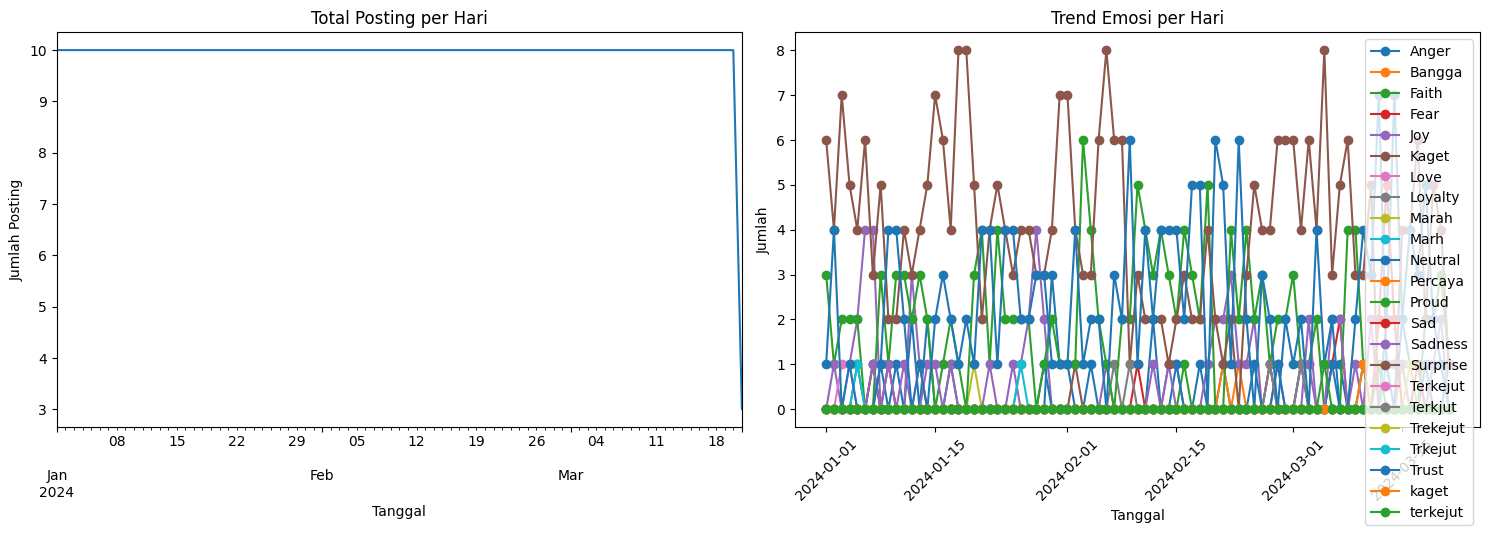

In [ ]:
# Buat timestamp per hari
start_date = datetime(2024, 1, 1)
df['timestamp'] = [start_date + timedelta(days=i//10) for i in range(len(df))]

daily_emotions = df.groupby(['timestamp', 'emotion']).size().unstack(fill_value=0)
daily_total = df.groupby('timestamp').size()

print("Data time series harian:")
print(daily_emotions.head())

# Plot time series
plt.figure(figsize=(15, 10))

# Plot total posting per hari
plt.subplot(2, 2, 1)
daily_total.plot()
plt.title('Total Posting per Hari')
plt.xlabel('Tanggal')
plt.ylabel('Jumlah Posting')

# Plot setiap emosi
plt.subplot(2, 2, 2)
for emotion in daily_emotions.columns:
    plt.plot(daily_emotions.index, daily_emotions[emotion], label=emotion, marker='o')
plt.title('Trend Emosi per Hari')
plt.xlabel('Tanggal')
plt.ylabel('Jumlah')
plt.legend()
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

=== FORECASTING TOTAL POSTING ===
ADF Statistic: -1.0
p-value: 0.7532643012005655
Data tidak stasioner


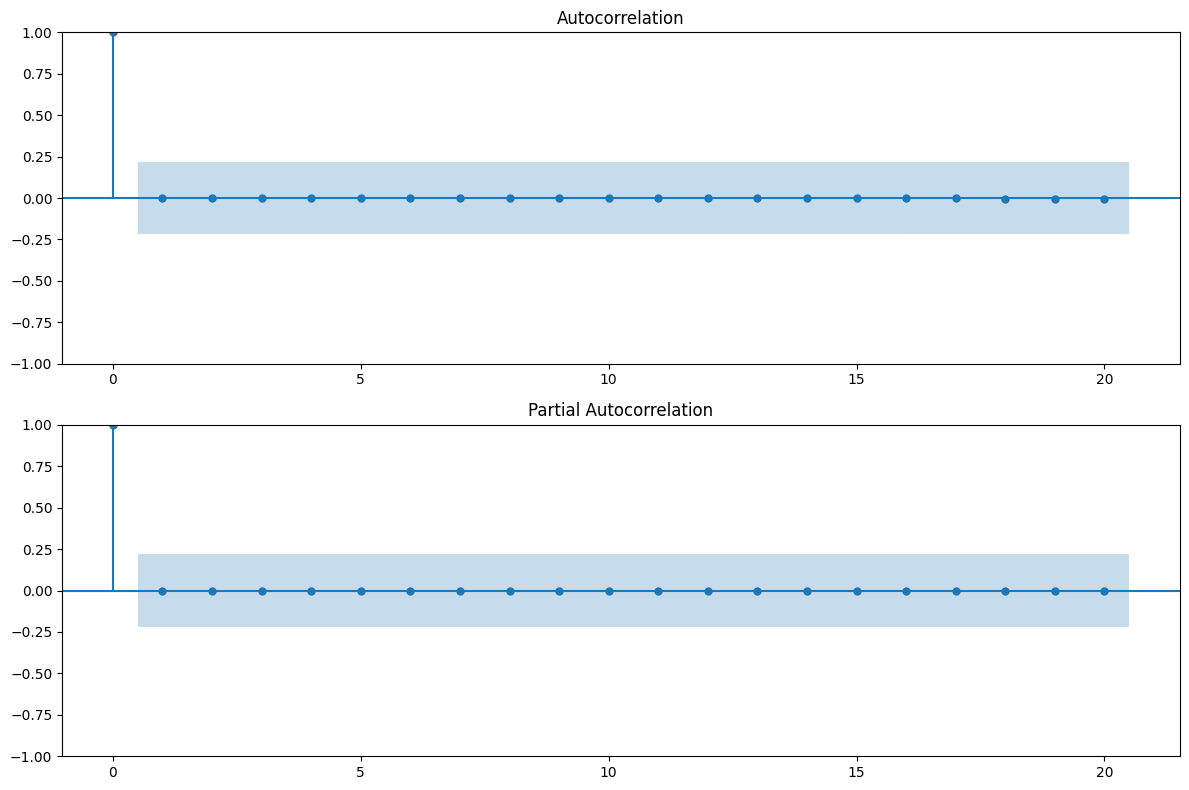

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/stattools.py:1431: RuntimeWarning: invalid value encountered in divide
  test_statistic = numer_squared_sum / denom_squared_sum
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


Model Summary:
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   64
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 702.054
Date:                Wed, 17 Sep 2025   AIC                          -1398.108
Time:                        05:27:08   BIC                          -1391.678
Sample:                             0   HQIC                         -1395.579
                                 - 64                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1      -5.733e-10   4.66e-19  -1.23e+09      0.000   -5.73e-10   -5.73e-10
ma.L1      -5.733e-10   4.66e-19  -1.23e+09      0.000   -5.73e-10   -5.73e-10
sigma2      2.325e-11   2.43e-10     

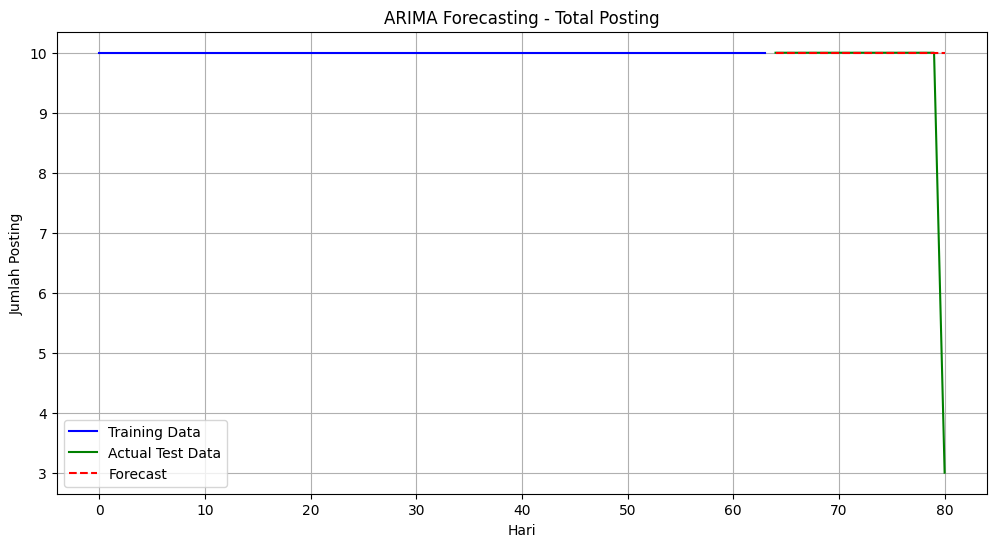


Evaluasi Model:
MAE: 0.41
MSE: 2.88
RMSE: 1.70


In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error

def check_stationarity(timeseries):
    result = adfuller(timeseries)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    if result[1] <= 0.05:
        print("Data adalah stasioner")
    else:
        print("Data tidak stasioner")

# Forecasting untuk total posting
print("=== FORECASTING TOTAL POSTING ===")
ts_data = daily_total.value
check_stationarity(ts_data)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(ts_data, ax=ax1, lags=20)
plot_pacf(ts_data, ax=ax2, lags=20)
plt.tight_layout()
plt.show()

# Split data untuk training dan testing
train_size = int(len(ts_data) * 0.8)
train_data = ts_data[:train_size]
test_data = ts_data[train_size:]

# Fit ARIMA model
model = ARIMA(train_data, order=(1, 1, 1))  # (p, d, q)
fitted_model = model.fit()

print("Model Summary:")
print(fitted_model.summary())

# Forecasting
forecast_steps = len(test_data)
forecast = fitted_model.forecast(steps=forecast_steps)
forecast_ci = fitted_model.get_forecast(steps=forecast_steps).conf_int()

# Plot hasil forecasting
plt.figure(figsize=(12, 6))
plt.plot(range(len(train_data)), train_data, label='Training Data', color='blue')
plt.plot(range(len(train_data), len(train_data) + len(test_data)), test_data, label='Actual Test Data', color='green')
plt.plot(range(len(train_data), len(train_data) + len(forecast)), forecast, label='Forecast', color='red', linestyle='--')
plt.fill_between(range(len(train_data), len(train_data) + len(forecast)),
                 forecast_ci[:, 0], forecast_ci[:, 1], color='pink', alpha=0.3)
plt.title('ARIMA Forecasting - Total Posting')
plt.xlabel('Hari')
plt.ylabel('Jumlah Posting')
plt.legend()
plt.grid(True)
plt.show()

# Evaluasi model
mae = mean_absolute_error(test_data, forecast)
mse = mean_squared_error(test_data, forecast)
rmse = np.sqrt(mse)

print(f"\nEvaluasi Model:")
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")


=== FORECASTING PER EMOSI ===

Forecasting untuk emosi: Anger
MAE untuk Anger: 0.96

Forecasting untuk emosi: Bangga


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


MAE untuk Bangga: 0.07

Forecasting untuk emosi: Faith
MAE untuk Faith: 0.02

Forecasting untuk emosi: Fear


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


MAE untuk Fear: 0.78

Forecasting untuk emosi: Joy
MAE untuk Joy: 0.66

Forecasting untuk emosi: Kaget


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


MAE untuk Kaget: 0.02

Forecasting untuk emosi: Love
MAE untuk Love: 0.02

Forecasting untuk emosi: Loyalty


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


MAE untuk Loyalty: 0.02

Forecasting untuk emosi: Marah
MAE untuk Marah: 0.02


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'



Forecasting untuk emosi: Marh
MAE untuk Marh: 0.06
Error untuk Marh: num must be an integer with 1 <= num <= 9, not 10

Forecasting untuk emosi: Neutral
MAE untuk Neutral: 0.19
Error untuk Neutral: num must be an integer with 1 <= num <= 9, not 11

Forecasting untuk emosi: Percaya


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


MAE untuk Percaya: 0.02
Error untuk Percaya: num must be an integer with 1 <= num <= 9, not 12

Forecasting untuk emosi: Proud
MAE untuk Proud: 1.59
Error untuk Proud: num must be an integer with 1 <= num <= 9, not 13

Forecasting untuk emosi: Sad


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


MAE untuk Sad: 0.02
Error untuk Sad: num must be an integer with 1 <= num <= 9, not 14

Forecasting untuk emosi: Sadness
MAE untuk Sadness: 0.42
Error untuk Sadness: num must be an integer with 1 <= num <= 9, not 15

Forecasting untuk emosi: Surprise
MAE untuk Surprise: 1.86
Error untuk Surprise: num must be an integer with 1 <= num <= 9, not 16

Forecasting untuk emosi: Terkejut
MAE untuk Terkejut: 0.03
Error untuk Terkejut: num must be an integer with 1 <= num <= 9, not 17

Forecasting untuk emosi: Terkjut
MAE untuk Terkjut: 0.05
Error untuk Terkjut: num must be an integer with 1 <= num <= 9, not 18

Forecasting untuk emosi: Trekejut


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


MAE untuk Trekejut: 0.06
Error untuk Trekejut: num must be an integer with 1 <= num <= 9, not 19

Forecasting untuk emosi: Trkejut
MAE untuk Trkejut: 0.05
Error untuk Trkejut: num must be an integer with 1 <= num <= 9, not 20

Forecasting untuk emosi: Trust


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.12/dist-packages/statsmodels

MAE untuk Trust: 1.52
Error untuk Trust: num must be an integer with 1 <= num <= 9, not 21

Forecasting untuk emosi: kaget
MAE untuk kaget: 0.06
Error untuk kaget: num must be an integer with 1 <= num <= 9, not 22

Forecasting untuk emosi: terkejut
MAE untuk terkejut: 0.06
Error untuk terkejut: num must be an integer with 1 <= num <= 9, not 23


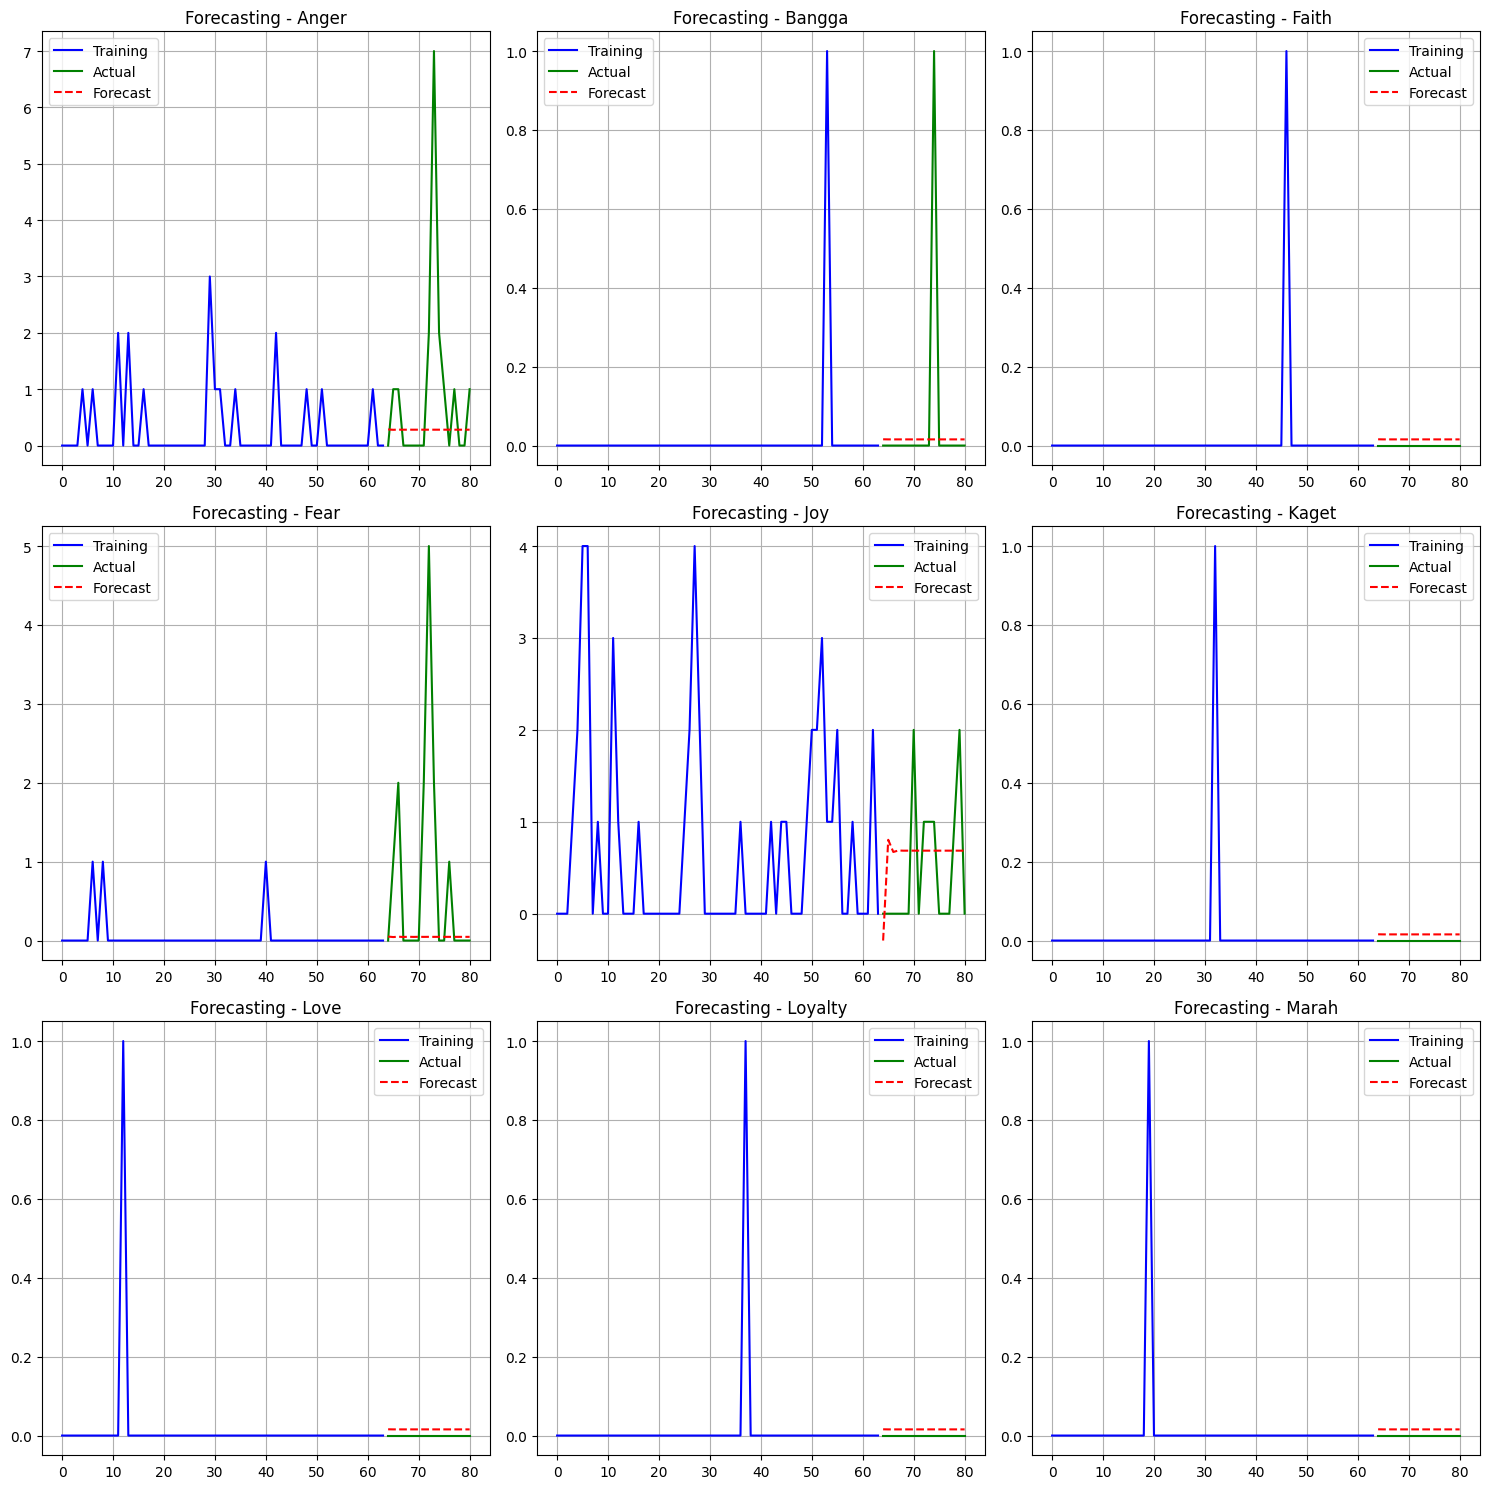

In [ ]:
print("\n=== FORECASTING PER EMOSI ===")

forecasts_by_emotion = {}
models_by_emotion = {}
train_size = int(len(daily_emotions) * 0.8)

plt.figure(figsize=(15, 15))
for i, emotion in enumerate(daily_emotions.columns):
    print(f"\nForecasting untuk emosi: {emotion}")

    emotion_data = daily_emotions[emotion].values

    if len(emotion_data) > 10:
        #Split data
        train_emotion = emotion_data[:train_size]
        test_emotion = emotion_data[train_size:]

        try:
            #test ARIMA
            model_emotion = ARIMA(train_emotion, order=(1, 0, 1))
            fitted_emotion = model_emotion.fit()

            #Forecast
            forecast_emotion = fitted_emotion.forecast(steps=len(test_emotion))
            forecasts_by_emotion[emotion] = forecast_emotion
            models_by_emotion[emotion] = fitted_emotion

            #Evaluate
            mae_emotion = mean_absolute_error(test_emotion, forecast_emotion)
            print(f"MAE untuk {emotion}: {mae_emotion:.2f}")
            plt.subplot(3, 3, i+1)

            plt.plot(range(len(train_emotion)), train_emotion, label='Training', color='blue')
            plt.plot(range(len(train_emotion), len(emotion_data)), test_emotion, label='Actual', color='green')
            plt.plot(range(len(train_emotion), len(emotion_data)), forecasts_by_emotion[emotion],
                    label='Forecast', color='red', linestyle='--')
            plt.title(f'Forecasting - {emotion}')
            plt.legend()
            plt.grid(True)

        except Exception as e:
            print(f"Error untuk {emotion}: {str(e)}")

plt.tight_layout()
plt.show()


=== FORECASTING DENGAN PROPHET ===


DEBUG:cmdstanpy:input tempfile: /tmp/tmprqednto3/j_xfzytx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprqednto3/gi00pfdv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9661', 'data', 'file=/tmp/tmprqednto3/j_xfzytx.json', 'init=/tmp/tmprqednto3/gi00pfdv.json', 'output', 'file=/tmp/tmprqednto3/prophet_model4qpt920w/prophet_model-20250917052743.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
05:27:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:27:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


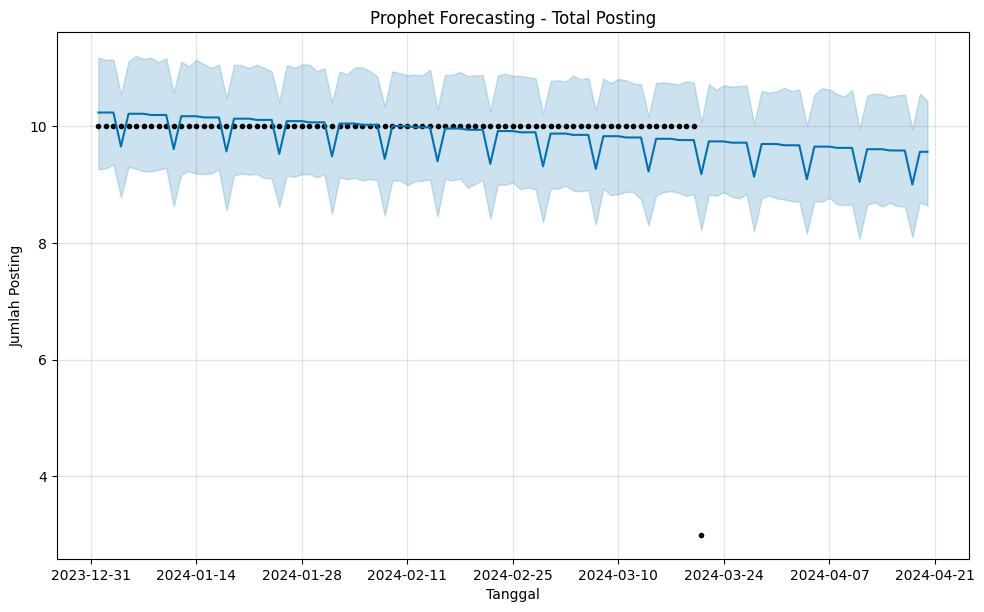

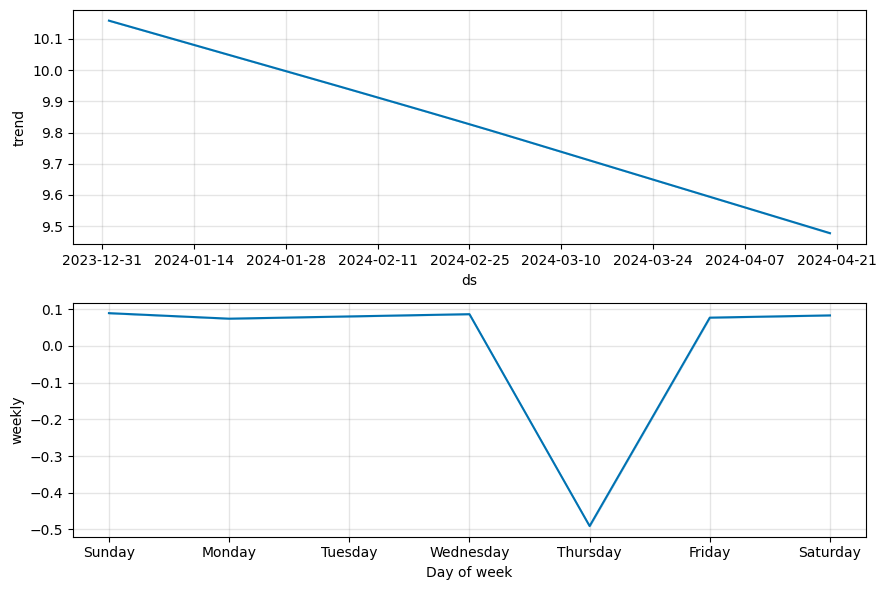


Forecast 30 hari ke depan:
            ds      yhat  yhat_lower  yhat_upper
81  2024-03-22  9.738958    8.828521   10.718210
82  2024-03-23  9.738717    8.809123   10.623211
83  2024-03-24  9.738475    8.869121   10.701321
84  2024-03-25  9.717067    8.792622   10.677092
85  2024-03-26  9.716830    8.760105   10.687031
86  2024-03-27  9.716594    8.838977   10.695448
87  2024-03-28  9.133033    8.203198   10.035809
88  2024-03-29  9.694405    8.762031   10.602451
89  2024-03-30  9.694164    8.813379   10.574911
90  2024-03-31  9.693922    8.762657   10.593970
91  2024-04-01  9.672514    8.746163   10.656867
92  2024-04-02  9.672277    8.713969   10.598125
93  2024-04-03  9.672041    8.706587   10.629215
94  2024-04-04  9.088480    8.158947   10.011342
95  2024-04-05  9.649852    8.717306   10.534561
96  2024-04-06  9.649611    8.703507   10.647719
97  2024-04-07  9.649369    8.775026   10.629553
98  2024-04-08  9.627961    8.662595   10.549516
99  2024-04-09  9.627723    8.648494   10

In [ ]:
from prophet import Prophet
print("\n=== FORECASTING DENGAN PROPHET ===")

prophet_data = daily_total.reset_index()
prophet_data.columns = ['ds', 'y']

prophet_model = Prophet(yearly_seasonality=False, weekly_seasonality=True, daily_seasonality=False)
prophet_model.fit(prophet_data)

# Buat future dataframe
future = prophet_model.make_future_dataframe(periods=30)
prophet_forecast = prophet_model.predict(future)

# Plot hasil Prophet
fig = prophet_model.plot(prophet_forecast)
plt.title('Prophet Forecasting - Total Posting')
plt.xlabel('Tanggal')
plt.ylabel('Jumlah Posting')
plt.show()
fig2 = prophet_model.plot_components(prophet_forecast)
plt.show()

# Hasil forecast
future_forecast = prophet_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(30)
print("\nForecast 30 hari ke depan:")
print(future_forecast)